In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
using DifferentialEquations, Plots, PhasorNetworks

In [3]:
using Lux, NNlib, Zygote, ComponentArrays, Optimisers

In [4]:
using Interpolations

In [5]:
using Random: Xoshiro

In [6]:
phases = -1.0:0.1:1.0 |> collect
n_in = length(phases)

21

In [7]:
sa = SpikingArgs()
train = phase_to_train(phases, spk_args=sa, repeats=1)

Spike Train: (21,) with 21 spikes.

In [8]:
using PhasorNetworks: gaussian_kernel

In [9]:
function cfn(train::SpikeTrain, t::Real, spk_args::SpikingArgs; sigma::Real = 9.0)

    #add currents into the active synapses
    current_kernel = x -> gaussian_kernel(x, t, spk_args.t_window)
    impulses = current_kernel(train.times)

    return impulses
end

cfn (generic function with 1 method)

In [10]:
cfn(train, 0.5, sa)

21-element Vector{Float64}:
 3.6808558548018004e-272
 1.3753667993264065e-220
 1.9151695967140057e-174
 9.938364413483684e-134
 1.921947727823849e-98
 1.3851193699226017e-68
 3.720075976020836e-44
 3.7233631217504573e-25
 1.388794386496412e-11
 0.0019304541362277128
 1.0
 0.001930454136227687
 1.388794386496412e-11
 3.7233631217504573e-25
 3.7200759760209417e-44
 1.3851193699226017e-68
 1.92194772782374e-98
 9.938364413483684e-134
 1.9151695967140057e-174
 1.375366799326641e-220
 3.6808558548018004e-272

In [11]:
current_fn = t -> cfn(train, t, sa)

#4 (generic function with 1 method)

In [12]:
current_sample = stack(current_fn.(0.0:0.001:1.0), dims=1);

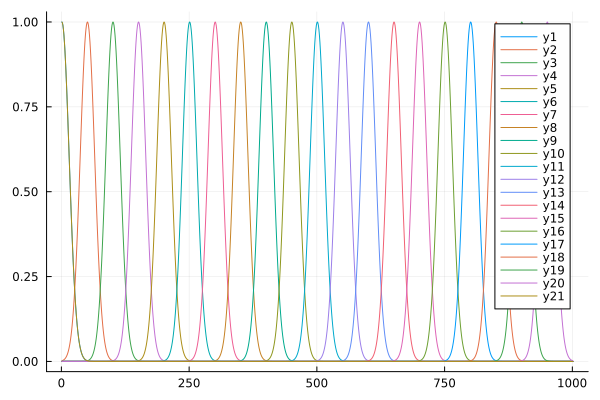

In [13]:
plot(current_sample)

In [14]:
ode_fn = Chain(Dense(n_in => n_in))

Dense(21 => 21)     # 462 parameters

In [15]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [16]:
in_ps, in_st = Lux.setup(rng, ode_fn)

((weight = Float32[-0.034407683 0.033833884 … -0.24778546 0.29199758; -0.24675442 -0.34743497 … 0.120002545 0.33507735; … ; -0.30658105 0.07079895 … -0.060400184 -0.31799373; 0.071049556 0.102035664 … -0.22994705 -0.15559468], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), NamedTuple())

In [17]:
smp = current_fn(0.0);

In [18]:
size(smp)

(21,)

In [19]:
smp1, _ = ode_fn(smp, in_ps, in_st)

([0.257655213766016, 0.08765221532036091, -0.13256490755839434, -0.3593759451363434, 0.30607213518641807, -0.37878644067502654, 0.10280439089258442, 0.055457599117088474, -0.526273975720372, -0.2783401689641056  …  0.02093992281535921, 0.11071689616833413, 0.08527098251816947, -0.0362881337801601, 0.13193465202053514, -0.18967310925392858, 0.008345381662816176, -0.02412290285355262, -0.6244381063456668, -0.08434814542350348], NamedTuple())

In [20]:
smp1 |> size

(21,)

In [21]:
ode_model = Chain(PhasorODE(ode_fn, tspan=(0.0, 1.0), dt=0.01),
                x -> complex_to_angle(Array(x)),)

Chain(
    layer_1 = PhasorODE(
        model = Dense(21 => 21),        # 462 parameters
    ),
    layer_2 = WrappedFunction(#6),
)         # Total: 462 parameters,
          #        plus 0 states.

In [22]:
ps, st = Lux.setup(rng, ode_model)

((layer_1 = (weight = Float32[-0.2151638 0.3665407 … -0.23877338 -0.087368436; -0.36821428 -0.24055284 … 0.24381015 0.31122464; … ; 0.21464978 -0.055422254 … 0.2479661 0.15970698; -0.10953547 0.29423267 … 0.2114452 -0.12547596], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = NamedTuple()), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [23]:
out1, st1 = ode_model(current_fn, ps, st)

(Float32[0.14840369; 0.66900957; … ; 0.08768123; -0.8044173;;], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [24]:
u1 = Array(out1)

21×1 Matrix{Float32}:
  0.14840369
  0.66900957
  0.5992827
 -0.9435846
  0.2812271
  0.5833626
  0.87788326
  0.7020199
  0.4318978
 -0.63080764
  0.23288056
 -0.11450964
 -0.6406866
 -0.66623116
  0.34456846
  0.44678417
  0.518723
  0.30542842
 -0.55024326
  0.08768123
 -0.8044173

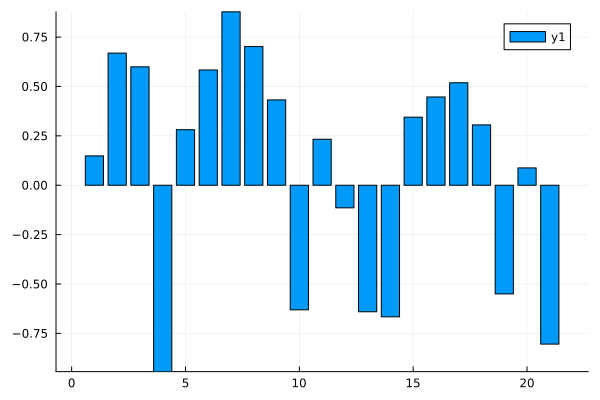

In [25]:
bar(u1)

In [26]:
#calc a gradient through a loss fn on the network

In [27]:
using Statistics: mean

In [28]:
function test_loss(model, ps, st)
    p0, _ = model(current_fn, ps, st)
    err = mean(similarity_loss(p0, reshape(phases, (:,1)),1))
    return err
end

test_loss (generic function with 1 method)

In [29]:
test_loss(ode_model, ps, st)

1.0884220105780589

In [30]:
psa = ComponentArray(ps)

ComponentVector{Float32}(layer_1 = (weight = Float32[-0.2151638 0.3665407 … -0.23877338 -0.087368436; -0.36821428 -0.24055284 … 0.24381015 0.31122464; … ; 0.21464978 -0.055422254 … 0.2479661 0.15970698; -0.10953547 0.29423267 … 0.2114452 -0.12547596], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = Float32[])

In [31]:
grads = Zygote.gradient(p -> test_loss(ode_model, p, st), psa)

((layer_1 = (weight = Float32[0.0062410007 0.01725348 … 0.004451276 0.0062410007; 0.0059851566 0.009683158 … 0.017064936 0.0059851566; … ; 0.003493729 0.011506436 … -0.00095355837 0.003493729; 0.017979957 0.045733325 … 0.020231389 0.017979957], bias = Float32[-0.021272661; 0.007691876; … ; -0.01947257; -0.045023035;;]), layer_2 = Float32[]),)

In [32]:
withgradient(p -> test_loss(ode_model, p, st), psa)

(val = 1.068020536411756, grad = ((layer_1 = (weight = Float32[0.0062410007 0.01725348 … 0.004451276 0.0062410007; 0.0059851566 0.009683158 … 0.017064936 0.0059851566; … ; 0.003493729 0.011506436 … -0.00095355837 0.003493729; 0.017979957 0.045733325 … 0.020231389 0.017979957], bias = Float32[-0.021272661; 0.007691876; … ; -0.01947257; -0.045023035;;]), layer_2 = Float32[]),))

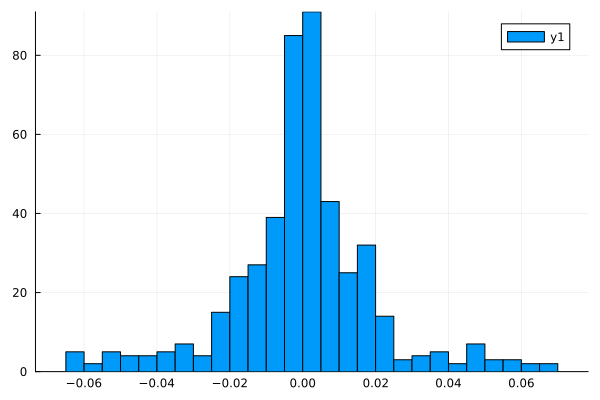

In [33]:
histogram(grads[1])

In [34]:
opt_state = Optimisers.setup(Adam(3e-4), psa)

Leaf(Adam(0.0003, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999)))

In [35]:
losses = []

Any[]

In [36]:
for i in 1:100
    lossval, gs = withgradient(p -> test_loss(ode_model, p, st), psa)
    append!(losses, lossval)
    opt_state, psa = Optimisers.update(opt_state, psa, gs[1])
end

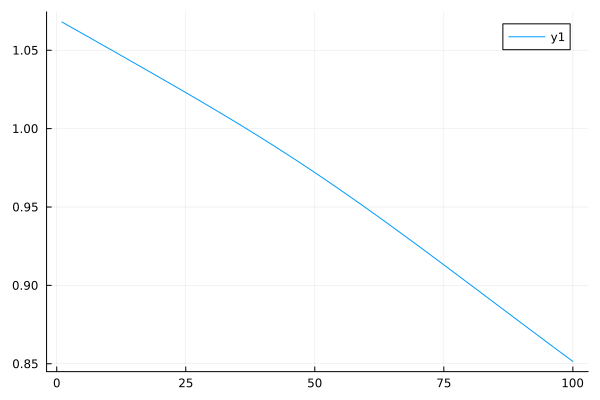

In [37]:
plot(losses)

In [38]:
for i in 1:1000
    lossval, gs = withgradient(p -> test_loss(ode_model, p, st), psa)
    append!(losses, lossval)
    opt_state, psa = Optimisers.update(opt_state, psa, gs[1])
end

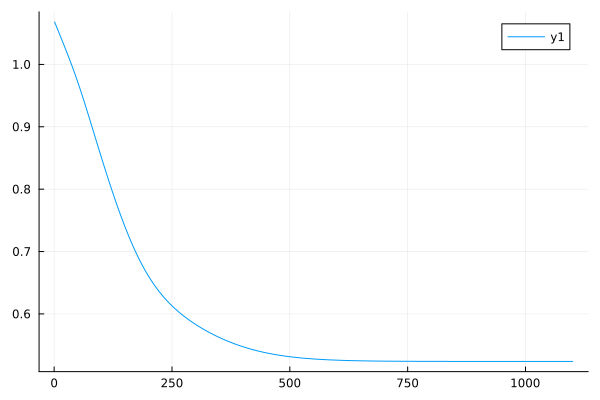

In [39]:
plot(losses)

In [40]:
test_loss(ode_model, psa, st)

3.535505681551143e-7

In [41]:
out2, _ = ode_model(current_fn, psa, st)

(Float32[-0.99999994; -0.9000006; … ; 0.89999986; 0.99999994;;], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

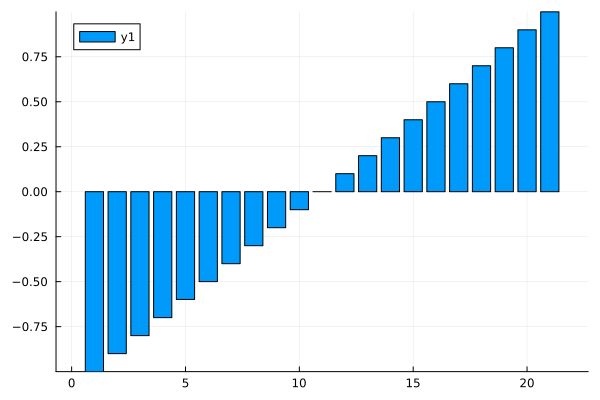

In [42]:
bar(out2)

In [43]:
similarity(vec(out2), phases)

1-element Vector{Float64}:
 0.9999996464494318